In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
sns.set_theme(style="whitegrid")

import time

import numpy as np
from scipy.stats import multivariate_normal as mvn
import scipy.spatial.distance
from sklearn import linear_model
import sklearn.datasets as toy_datasets
from minepy import MINE
import pandas as pd
import dcor

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Definitions

$$I(X;Y) = \int_y \int_x P_{(X,Y)}(x,y)log \left( \frac{P_{(X,Y)}(x,y)}{P_X(x)P_Y(y)} \right) dx dy$$
$$I(X;Y) = D_{KL}(P_{(X,Y)} || P_X \otimes P_Y) $$

In [2]:
# RDC Implementation
"""
From: https://github.com/garydoranjr/rdc/blob/master/rdc/rdc.py
Implements the Randomized Dependence Coefficient
David Lopez-Paz, Philipp Hennig, Bernhard Schoelkopf
http://papers.nips.cc/paper/5138-the-randomized-dependence-coefficient.pdf
"""
import numpy as np
from scipy.stats import rankdata
def rdc(x, y, f=np.sin, k=20, s=1/6., n=1):
    """
    Computes the Randomized Dependence Coefficient
    x,y: numpy arrays 1-D or 2-D
         If 1-D, size (samples,)
         If 2-D, size (samples, variables)
    f:   function to use for random projection
    k:   number of random projections to use
    s:   scale parameter
    n:   number of times to compute the RDC and
         return the median (for stability)
    According to the paper, the coefficient should be relatively insensitive to
    the settings of the f, k, and s parameters.
    """
    if n > 1:
        values = []
        for i in range(n):
            try:
                values.append(rdc(x, y, f, k, s, 1))
            except np.linalg.linalg.LinAlgError: pass
        return np.median(values)

    if len(x.shape) == 1: x = x.reshape((-1, 1))
    if len(y.shape) == 1: y = y.reshape((-1, 1))

    # Copula Transformation
    cx = np.column_stack([rankdata(xc, method='ordinal') for xc in x.T])/float(x.size)
    cy = np.column_stack([rankdata(yc, method='ordinal') for yc in y.T])/float(y.size)

    # Add a vector of ones so that w.x + b is just a dot product
    O = np.ones(cx.shape[0])
    X = np.column_stack([cx, O])
    Y = np.column_stack([cy, O])

    # Random linear projections
    Rx = (s/X.shape[1])*np.random.randn(X.shape[1], k)
    Ry = (s/Y.shape[1])*np.random.randn(Y.shape[1], k)
    X = np.dot(X, Rx)
    Y = np.dot(Y, Ry)

    # Apply non-linear function to random projections
    fX = f(X)
    fY = f(Y)

    # Compute full covariance matrix
    C = np.cov(np.hstack([fX, fY]).T)

    # Due to numerical issues, if k is too large,
    # then rank(fX) < k or rank(fY) < k, so we need
    # to find the largest k such that the eigenvalues
    # (canonical correlations) are real-valued
    k0 = k
    lb = 1
    ub = k
    while True:

        # Compute canonical correlations
        Cxx = C[:k, :k]
        Cyy = C[k0:k0+k, k0:k0+k]
        Cxy = C[:k, k0:k0+k]
        Cyx = C[k0:k0+k, :k]

        eigs = np.linalg.eigvals(np.dot(np.dot(np.linalg.pinv(Cxx), Cxy),
                                        np.dot(np.linalg.pinv(Cyy), Cyx)))

        # Binary search if k is too large
        if not (np.all(np.isreal(eigs)) and
                0 <= np.min(eigs) and
                np.max(eigs) <= 1):
            ub -= 1
            k = (ub + lb) // 2
            continue
        if lb == ub: break
        lb = k
        if ub == lb + 1:
            k = ub
        else:
            k = (ub + lb) // 2

    return np.sqrt(np.max(eigs))

In [3]:
from sklearn.metrics import mutual_info_score
def calc_MI(x, y, bins=50):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [4]:
def dCor(x, y):
    """
    Implements Distance Correlation.  See technical paper here:
    https://arxiv.org/pdf/0803.4101.pdf
    """
    return dcor.distance_correlation(x, y)

In [5]:
# from: https://minepy.readthedocs.io/en/latest/python.html
def mic(x, y):
    """
    Implements Maximal Information Coefficient:
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3325791/
    """
    mine = MINE(alpha=0.6, c=15, est="mic_approx") # default values
    mine.compute_score(x, y)
    
    return mine.mic()

<IPython.core.display.Javascript object>


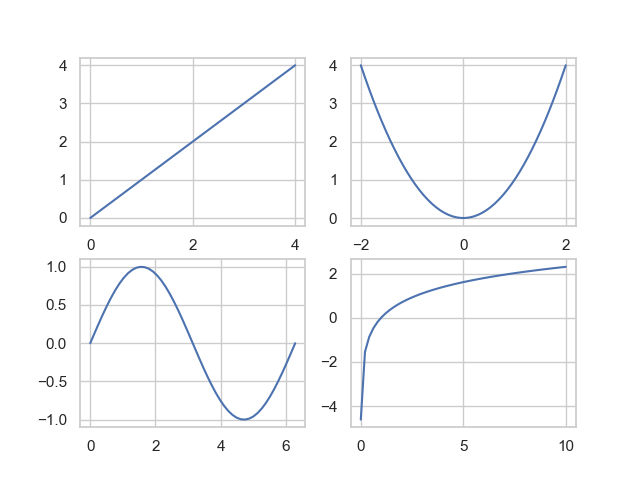

In [6]:
# linear
x = np.linspace(0,4)
y = x
t1 = (x, y)

# quadratic
x = np.linspace(-2, 2)
y = np.power(x,2)
t2 = (x, y)

# sinusoidal
x = np.linspace(0, 2*np.pi)
y = np.sin(x)
t3 = (x, y)

# logarithmic
x = np.linspace(0.01, 10)
y = np.log(x)
t4 = (x, y)

plt.figure()
plt.subplot(2,2,1); plt.plot(t1[0], t1[1])
plt.subplot(2,2,2); plt.plot(t2[0], t2[1])
plt.subplot(2,2,3); plt.plot(t3[0], t3[1])
plt.subplot(2,2,4); plt.plot(t4[0], t4[1])

<IPython.core.display.Javascript object>


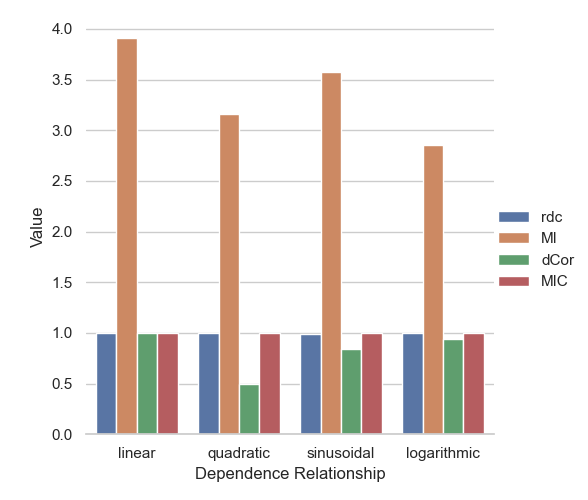

In [7]:
test_vectors = [t1, t2, t3, t4]
test_vectors_str = ['linear', 'quadratic', 'sinusoidal', 'logarithmic']
dependence_measures = [rdc, calc_MI, dCor, mic]
dependence_measures_str = ['rdc', 'MI', 'dCor', 'MIC']
results = []

for ii, d in enumerate(dependence_measures):
    dep_str = dependence_measures_str[ii]
    for jj, t in enumerate(test_vectors):
        test_str = test_vectors_str[jj]
        x = t[0]
        y = t[1]
        r = d(x, y)
        result_dict = {'dep': dep_str, 'test': test_str, 'result': r}
        results.append(result_dict)
        
df = pd.DataFrame(results)
g = sns.catplot(data=df, kind='bar', x='test', y='result', hue='dep')
g.despine(left=True)
g.set_axis_labels("Dependence Relationship", "Value")
g.legend.set_title("")

<IPython.core.display.Javascript object>


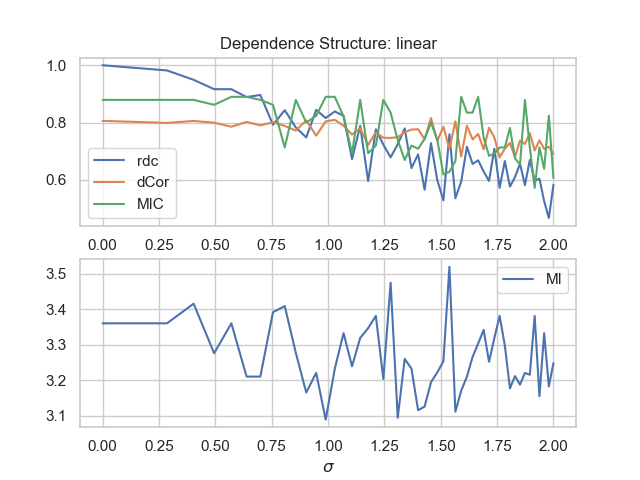

Text(0.5, 0, '$\\sigma$')

In [8]:
test = 'linear'
kk = test_vectors_str.index(test)
test_fn = test_vectors[kk]
xx = test_fn[0]
yy = test_fn[1]
noise_var = np.linspace(0, 4)
results = np.zeros((len(dependence_measures), noise_var.shape[0]))
num_mc = 100
y_mc_vec = np.zeros((num_mc, len(yy)))

for ii, d in enumerate(dependence_measures):
    for jj in range(noise_var.shape[0]):
        std = np.sqrt(noise_var[jj])
        for kk in range(num_mc):
            y = yy + np.random.normal(scale=std, size=noise_var.shape[0])
            y_mc_vec[ii,:] = y
            
        results[ii,jj] = d(xx, np.mean(y_mc_vec, axis=0))

plt.figure()
plt.subplot(2,1,1)
for ii, dd in enumerate(dependence_measures_str):
    if dd != 'MI':
        plt.plot(np.sqrt(noise_var), results[ii,:], label=dd)
plt.legend()
plt.title('Dependence Structure: %s' % (test,))

plt.subplot(2,1,2)
for ii, dd in enumerate(dependence_measures_str):
    if dd == 'MI':
        plt.plot(np.sqrt(noise_var), results[ii,:], label=dd)
plt.legend()
plt.xlabel('$\sigma$')
